In [ ]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Input, Dense,Embedding, Concatenate, TimeDistributed
from tensorflow.keras.models import Model,load_model, model_from_json
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
import pickle as pkl
import numpy as np

In [ ]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
with open('Q3.txt','r') as f:
  data = f.read()

In [ ]:
uncleaned_data_list = data.split('\n')

In [ ]:
uncleaned_data_list = uncleaned_data_list[:37416]

In [ ]:

archaic_translation_word = []
universal_tanslation_word = []
cleaned_data_list = []
for word in uncleaned_data_list:
  archaic_translation_word.append(word.split('\t')[:][1])
  universal_tanslation_word.append(word.split('\t')[:][0])

In [ ]:
language_data = pd.DataFrame(columns=['Archaic_Translatiion','Universal_Translation'])
language_data['Universal_Translation'] = universal_tanslation_word
language_data['Archaic_Translatiion'] = archaic_translation_word




In [ ]:
language_data.to_csv('language_data.csv', index=False)

In [ ]:
language_data = pd.read_csv('language_data.csv')

In [ ]:
language_data.head()

,Archaic_Translatiion,Universal_Translation
0,"In the name of Allah, the Beneficent, the Merc...","In the name of Allah, the Entirely Merciful, t..."
1,"In the name of Allah, Most Gracious, Most Merc...","In the name of Allah, the Entirely Merciful, t..."
2,"In the name of Allah, the Beneficent, the Merc...","In the name of Allah, the Entirely Merciful, t..."
3,"In the Name of Allah, the Beneficent, the Merc...","In the name of Allah, the Entirely Merciful, t..."
4,"In the Name of Allah, the Most Beneficent, the...","In the name of Allah, the Entirely Merciful, t..."


In [ ]:
language_data.tail()

,Archaic_Translatiion,Universal_Translation
37411,Among Jinns and among men.,"From among the jinn and mankind."""
37412,From among the jinn and the men.,"From among the jinn and mankind."""
37413,who induce temptation into the hearts of mankind.,"From among the jinn and mankind."""
37414,"""Of jinns and men.""","From among the jinn and mankind."""
37415,of jinn and men.',"From among the jinn and mankind."""


In [ ]:
archaic_translation_text = language_data['Archaic_Translatiion'].values
universal_translation_text = language_data['Universal_Translation'].values

In [ ]:
universal_translation_text[1], archaic_translation_text[1]

('In the name of Allah, the Entirely Merciful, the Especially Merciful.',
 'In the name of Allah, Most Gracious, Most Merciful.')

In [ ]:
archaic_translation_text_ = [x.lower() for x in archaic_translation_text]
universal_translation_text_ = [x.lower() for x in universal_translation_text]

In [ ]:
archaic_translation_text_ = [re.sub("'",'',x) for x in archaic_translation_text_]
universal_translation_text_ = [re.sub("'",'',x) for x in universal_translation_text_]

In [ ]:
def remove_punc(text_list):
  table = str.maketrans('', '', string.punctuation)
  removed_punc_text = []
  for sent in text_list:
    sentence = [w.translate(table) for w in sent.split(' ')]
    removed_punc_text.append(' '.join(sentence))
  return removed_punc_text
archaic_translation_text_ = remove_punc(archaic_translation_text_)
universal_translation_text_ = remove_punc(universal_translation_text_)

In [ ]:
remove_digits = str.maketrans('', '', digits)
removed_digits_text = []
for sent in archaic_translation_text_:
  sentence = [w.translate(remove_digits) for w in sent.split(' ')]
  removed_digits_text.append(' '.join(sentence))
archaic_translation_text_ = removed_digits_text

# removing the digits from the universal translation 
universal_translation_text_ = [re.sub("[0123456789]","",x) for x in universal_translation_text_]
universal_translation_text_ = [re.sub("[\u200d]","",x) for x in universal_translation_text_]

# removing the stating and ending whitespaces
archaic_translation_text_ = [x.strip() for x in archaic_translation_text_]
universal_translation_text_ = [x.strip() for x in universal_translation_text_]

In [ ]:
# removing the starting and ending whitespaces
archaic_translation_text_ = [x.strip() for x in archaic_translation_text_]
universal_translation_text_ = [x.strip() for x in universal_translation_text_]

In [ ]:
# Putting the start and end words in the universal translations
universal_translation_text_ = ["start " + x + " end" for x in universal_translation_text_]

In [ ]:
# manipulated_universal_translation_text_
universal_translation_text_[0], archaic_translation_text_[0]

('start in the name of allah the entirely merciful the especially merciful end',
 'in the name of allah the beneficent the merciful')

In [ ]:
X = archaic_translation_text_
Y = universal_translation_text_

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.1)
len(X_train),len(y_train), len(X_test), len(y_test)

(33674, 33674, 3742, 3742)

In [ ]:
X_train[0], y_train[0]

('then shall we save our messengers and the believers in like manner as of old it is incumbent upon us to save believers',
 'start then we will save our messengers and those who have believed thus it is an obligation upon us that we save the believers end')

In [ ]:
def Max_length(data):
  max_length_ = max([len(x.split(' ')) for x in data])
  return max_length_

#Training data
max_length_archaic_translation = Max_length(X_train)
max_length_universal_translation = Max_length(y_train)

#Test data
max_length_archaic_translation_test = Max_length(X_test)
max_length_universal_translation_test = Max_length(y_test)

In [ ]:
max_length_universal_translation, max_length_archaic_translation

(259, 321)

In [ ]:
archaic_translationTokenizer = Tokenizer()
archaic_translationTokenizer.fit_on_texts(X_train)
Eword2index = archaic_translationTokenizer.word_index
vocab_size_source = len(Eword2index) + 1

X_train = archaic_translationTokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_length_archaic_translation, padding='post')

X_test = archaic_translationTokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_length_archaic_translation, padding='post')

In [ ]:
universal_translationTokenizer = Tokenizer()
universal_translationTokenizer.fit_on_texts(y_train)
Mword2index = universal_translationTokenizer.word_index
vocab_size_target = len(Mword2index) + 1

y_train = universal_translationTokenizer.texts_to_sequences(y_train)
y_train = pad_sequences(y_train, maxlen=max_length_universal_translation, padding='post')

y_test = universal_translationTokenizer.texts_to_sequences(y_test)
y_test = pad_sequences(y_test, maxlen = max_length_universal_translation, padding='post')

In [ ]:
vocab_size_source, vocab_size_target

(12753, 5278)

In [ ]:
with open('NMT_data.pkl','wb') as f:
 pkl.dump([X_train, y_train, X_test, y_test],f)

In [ ]:
with open('NMT_Etokenizer.pkl','wb') as f:
  pkl.dump([vocab_size_source, Eword2index, archaic_translationTokenizer], f)

with open('NMT_Mtokenizer.pkl', 'wb') as f:
  pkl.dump([vocab_size_target, Mword2index, universal_translationTokenizer], f)


In [ ]:
X_train[0], y_train[0]

(array([  34,   35,   16,  197,   54,  144,    2,    1,  100,    8,  140,
         880,   42,    3,  417,   19,    6, 2079,   89,   58,    4,  197,
         100,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
X_train[0], y_train[0]

(array([  34,   35,   16,  197,   54,  144,    2,    1,  100,    8,  140,
         880,   42,    3,  417,   19,    6, 2079,   89,   58,    4,  197,
         100,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [ ]:
print(len(y_train))
print(len(y_test))

33674
3742


In [ ]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_length_archaic_translation,)) 
enc_emb = Embedding(vocab_size_source, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(vocab_size_target, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(vocab_size_target, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 321)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 321, 500)     6376500     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 321, 500), ( 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

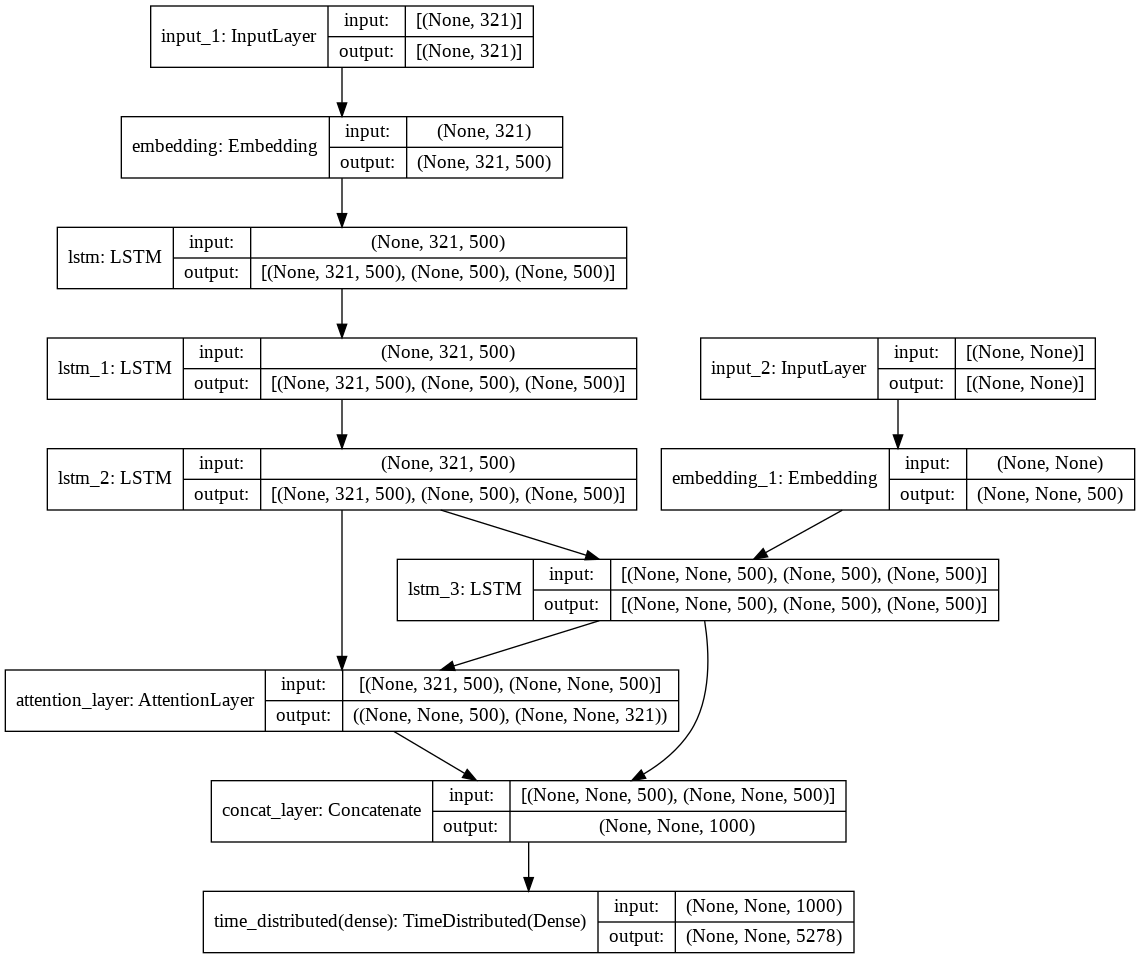

In [ ]:
plot_model(model, to_file='train_model.png', show_shapes=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1],1)[:,1:], 
                    epochs=100,
                    batch_size=64,
                    validation_data = ([X_test, y_test[:,:-1]], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))


Epoch 1/100
527/527 [==============================] - 744s 1s/step - loss: 0.7268 - accuracy: 0.8973 - val_loss: 0.3760 - val_accuracy: 0.9286
Epoch 2/100
527/527 [==============================] - 722s 1s/step - loss: 0.3335 - accuracy: 0.9347 - val_loss: 0.2658 - val_accuracy: 0.9445
Epoch 3/100
527/527 [==============================] - 720s 1s/step - loss: 0.2209 - accuracy: 0.9528 - val_loss: 0.1831 - val_accuracy: 0.9597
Epoch 4/100
527/527 [==============================] - 716s 1s/step - loss: 0.1385 - accuracy: 0.9691 - val_loss: 0.1197 - val_accuracy: 0.9727
Epoch 5/100
527/527 [==============================] - 714s 1s/step - loss: 0.0803 - accuracy: 0.9827 - val_loss: 0.0814 - val_accuracy: 0.9813
Epoch 6/100
527/527 [==============================] - 711s 1s/step - loss: 0.0473 - accuracy: 0.9905 - val_loss: 0.0552 - val_accuracy: 0.9876
Epoch 7/100
527/527 [==============================] - 710s 1s/step - loss: 0.0302 - accuracy: 0.9941 - val_loss: 0.0418 - val_accuracy:

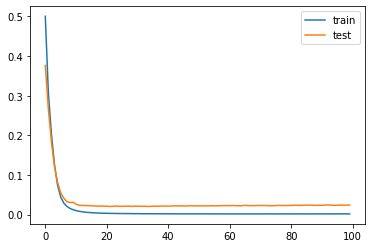

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [ ]:
model_json = model.to_json()
with open("NMT_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("NMT_model_weight.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# loading the model architecture and asigning the weights
json_file = open('NMT_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json, custom_objects={'AttentionLayer': AttentionLayer})
# load weights into new model
model_loaded.load_weights("NMT_model_weight.h5")

In [ ]:
with open('NMT_Etokenizer.pkl','rb') as f:
  vocab_size_source, Eword2index, universal_translation_Tokenizer = pkl.load(f)

with open('NMT_Mtokenizer.pkl', 'rb') as f:
  vocab_size_target, Mword2index, archaic_translation_Tokenizer = pkl.load(f)

with open('NMT_data.pkl','rb') as f:
  X_train, y_train, X_test, y_test = pkl.load(f)

In [ ]:
Eindex2word = universal_translation_Tokenizer.index_word
Mindex2word = archaic_translation_Tokenizer.index_word

In [ ]:
latent_dim=500
# encoder inference
encoder_inputs = model_loaded.input[0]  #loading encoder_inputs
encoder_outputs, state_h, state_c = model_loaded.layers[6].output #loading encoder_outputs

print(encoder_outputs.shape)

encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(321,latent_dim))

# Get the embeddings of the decoder sequence
decoder_inputs = model_loaded.layers[3].output

print(decoder_inputs.shape)
dec_emb_layer = model_loaded.layers[5]

dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_lstm = model_loaded.layers[7]
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_layer = model_loaded.layers[8]
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])

concate = model_loaded.layers[9]
decoder_inf_concat = concate([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_dense = model_loaded.layers[10]
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

(None, 321, 500)
(None, None)


In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = Mword2index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
          break
        else:
          sampled_token = Mindex2word[sampled_token_index]

          if(sampled_token!='end'):
              decoded_sentence += ' '+sampled_token

              # Exit condition: either hit max length or find stop word.
              if (sampled_token == 'end' or len(decoded_sentence.split()) >= (101-1)):
                  stop_condition = True

          # Update the target sequence (of length 1).
          target_seq = np.zeros((1,1))
          target_seq[0, 0] = sampled_token_index

          # Update internal states
          e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=Mword2index['start']) and i!=Mword2index['end']):
        newString=newString+Mindex2word[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+Eindex2word[i]+' '
    return newString

In [ ]:
!pip install jellyfish

     |████████████████████████████████| 92kB 4.9MB/s 


In [ ]:
!pip install textdistance

In [ ]:
!pip install strsimpy

     |████████████████████████████████| 51kB 3.6MB/s 


In [ ]:
import re
import jellyfish
import scipy
import textdistance
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from nltk.translate import bleu
from strsimpy.normalized_levenshtein import NormalizedLevenshtein
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from difflib import SequenceMatcher
from nltk.translate.bleu_score import SmoothingFunction
count_vect = CountVectorizer()
cc = SmoothingFunction() 
smoothie = SmoothingFunction().method4
sum=0
sum1=0
sum2=0
sum3=0
sum4=0
sum5=0
sum6=0
sum7=0
performance=0
performance1=0
aperformance2=0
performance3=0
performance4=0
performance5=0
performance6=0
performance7=0
normalized_levenshtein = NormalizedLevenshtein()
dct = {'deviant':'devaint (departing from usual or accepted standards)',
       'cessation':'end',
    'conspicuous':'visible',
    'repelling':'repelling (turning it back)',
    'calamity':'disaster',
    'merchandise':'goods',
    'impassioned':'imapassioned (filled with or showing great emotion)',
    'coercion':'force',
    'despaired':'lost hope',
    'adversity':'disaster',
    'exultant':'thrilled',
    'adorments':'glitter',
    'unto':'to',
    'depositories':'depositories (a place where things can be stored)',
    'anchorage':'anchorage (a place where the boat is or can be anchored)',
    'disembark':'disembark (to leave a ship after a journey)',
    'forelock':'forelock (a piece of hair that grows or falls over the forehead)',
    'obstinate':'aggressive',
    'tyrant':'cruel ruler',
    'disquieting':'alarming',
    'hamstrung':'killed',
    'shriek':'shriek (a piercing cry or blast from the sky)',
    'apprehension':'harm',
    'availed':'profited',
    'bestowal':'gift',
    'undiminished':'fully',
    'impending':'impending (near)',
    'tyranny':'oppression',
    'enmity':'extreme hatred',
    'ambush':'attack',
    'besiege':'surround',
    'kinship':'relationship',
    'striven':'striven (make great efforts to achieve something)',
    'commerce':'trade',
    'flanks':'flanks (the side of a persons or animals body between the ribs and the hips)',
    'tranquility':'calm',
    'apprehensive':'anxious',
    'vanities':'idle talks',
    'stingy':'not generous',
    'bedouins':'bedouins (a member of an Arab people living in or near the desert)',
    'invocations':'prayers',
    'afflicted':'suffered',
    'inflictions':'imposed',
    'wherein':'in which',
    'therewith':'therewith (soon or immediately after that)',
    'hostilities':'hostilities (hatred)',
    'hostility':'hostility (hatred)',
    'obstruct':'block',
    'pledge':'pledge(word of honor)',
    'inflicts':'imposes',
    'massacre':'massacre (murder/slaughter of people) ',
    'massacred':'massacred (murder/slaughter of people)',
    'commodities':'assets',
    'debased':'wicked',
    'eminent':'eminent (very important)',
    'defilement':'degradation',
    'insolent':'arrogant',
    'insolently':'arrogantly',
    'prone':'prone (lying flat)',
    'afflict':'suffer',
    'serpent':'snake',
    'bewitched':'bewitched (to affect by witchcraft)',
    'subjugators':'winners',
    'tablets':'tablets (a flat slab, intended to bear writtings)',
    'heedless':'careless',
    'inscription':'inscription (a historical, religious, or other record cut, impressed, painted, or written on stone, brick, metal, or other hard surface)',
    'absolved':'exempt',
    'contrived':'manipulated',
    'equate':'regard',
    'thereform':'from that place',
    'deities':'Gods',
    'intercessor':'mediator',
    'intercessors':'mediators',
    'finality':'finality (the fact of being final)',
    'appraisal':'assessment',
    'prohibited':'forbid',
    'digress':'digress (to turn aside)',
    'tyrannical':'brutal',
    'thereto':'to that',
    'expiation':'expiation (to make amends)',
    'perjury':'perjury (lying under oath)',
    'sanctity':'holiness',
    'substitute':'alternative',
    'devour':'swallow',
    'detriment':'disadvantage',
    'ordains':'establish',
    'ordained':'established',
    'decree':'legal order',
    'decreed':'mandated',
    'chastity':'purity',
    'affliction':'suffering',
    'arbitrator':'arbitrator (settler of a dispute)',
    'reconciliation':'harmony',
    'boastful':'bragging',
    'stinginess':'extreme greed',
    'fabricated':'constructed',
    'far astray':'far away',
    'accommodation':'compromise',
    'admonish':'advise',
    'attainment':'achievement',
    'lofty':'high',
    'disposer':'giver',
    'intercedes':'interfere',
    'emigrate':'emigrate (abandon their homes)',
    'wherein':'in which',
    'acquisitions':'profits',
    'conferred':'awarded',
    'incumbent':'necessary',
    'prostrated':'bowed',
    'slander':'falsehood',
    'recompensed':'repayed',
    'contempt':'disrespect',
    'evasion':'avoidance',
    'his abundance':'his rewards',
    'wavering':'swaying',
    'pardoning':'forgiving',
    'pardoned':'forgiven',
    'discriminate':'differentiate',
    'solemn':'dignified',
    'avert':'turn away',
    'desist':'desist (stop doing something)',
    'disdained':'disrespected',
    'emigrant':'emigrant (one who leaves his own country)',
    'manifest': 'clear',
    'attributable': '[attributable (considered impossible)]',
    'martyrdom': 'martyrdom (killed in the cause of God)',
    'steadfast': 'firm',
    'an immorality': 'a crime',
    'persevere': 'work hard',
    'stationed': 'firm',
    'uninhibited': 'unrestrained',
    'martyred': 'martyred (killed in the cause of God)',
    'distress': 'pain',
    'disputing': 'arguing',
    'refuge': 'place to hide',
    'afflicted': 'depressed',
    'decree determined': 'term appointed',
    'thereby': 'by that',
    'tidings': 'news',
    'reinforce': 'increase',
    'hardships': 'severe suffering',
    'intimates': 'close friends',
    'hasten': 'hurry',
    'prostrating': 'bowing',
    'attain': 'achieve',
    'repent': 'feel remorse',
    'abiding': 'living',
    'their recompense': 'their reward',
    'pious': 'devoted',
    'alter': 'change',
    'oaths': 'promises',
    'falsehood': 'untruthfulness',
    'faction': 'group',
    'inclining': 'favoring',
    'equitable': 'shared',
    'invoke': 'call on',
    'supplicate': 'beg',
    'hereafter': 'life after death',
    'leaper': 'leper (A person affected with leprosy disease)',
    'disputed': 'argued',
    'abstaining': 'abstaining (to hold oneself back voluntarily)',
    'expelled': 'rejected',
    'prudence': 'fear',
    'sovereignty': 'power',
    'assemble': 'gather',
    'deluded': 'fooled',
    'arbitrate': 'achieve settlement',
    'swift': 'very fast',
    'heaped-up': 'stacked',
    'penalty': 'punishment',
    'bestower': 'granter',
    'scribe': 'scribe (the one who makes a written copy professionally)',
    'forbearing': 'tolerant',
    'animosity': 'extreme hatred',
    'deviation' :'change',
    'ridicule': 'make fun of',
    'ordinances': 'law',
    'bequeather': 'will',
    'bequest': 'will',
    'testimony': 'testimony (declaration about truth)',
    'usury': 'lending money at high interest',
    'admonition': 'caution',
    'kursi': 'kursi (Chair)',
    'deity': 'god',
    'kingship': 'nobility',
    'acquainted': 'aware',
    'transgress': 'does wrong',
    'alleviation': 'relief',
    'retribution': 'compensation',
    'prescirbed': 'recommended',
    'dissension': 'disagreement',
    'reprieved': 'relief of blame',
    'exalted': 'praised',
    'all encompassing': 'All-Sufficient',
    'dominion': 'authority',
    'abrogate': 'put an end',
    'bounty': 'gift',
    'enjoins': 'commands',
    'wrath': 'extreme anger',
    'wretched': 'terrible',
    'resurrection': 'resurrection (Awakening from the dead)',
    'aggression': 'attack',
    'evicting': 'throwing out',
    'evict': 'throw out',
    'enjoining': 'commanding',
    'woe': 'suffering',
    'unlettered': 'vulgar',
    'covet': 'wish',
    'concealing': 'hiding',
    'irrigate': 'water',
    'plow': 'dig',
    'median between that': '(it is) between the two conditions',
    'do you take us in ridicule?': 'are you mocking us?',
    'despised': 'I look down upon you',
    'transgressed': 'spread sin',
    'transgressing': 'wrong-doers',
    'gushed':'poured out',
    'aided': 'helped',
    'intercession': 'appeal',
    'suffice': 'be enough',
    'righteousness': 'goodness',
    'discord': 'disharmony',
    'ally': 'protector',
    'deviation': 'change',
     '<end>': ' ',
     'discord': 'disharmony',
     'forsake': 'abandon',
     'sovereign': 'ruler',
     'recompense': 'Judgement',
     'bestowed': 'granted',
     'evoked': 'awaken',
     'astray':'lost',
    'transgressions':'wrong-doings',
    'kindled': 'start',
    'illuminated': 'lit up',
    'dread': 'fear',
    'is encompassing of': 'has surrounded',
    'competent': 'capable',
    'attribute': 'assign',
    'abide': 'live',
    'eternally': 'forever',
    'defiantly': '',
    'covenant': 'agreement',
    'sever': 'to cut off',
    'santify': 'purify',
    'prostrate': 'bow',
    'therein': 'in there',
    'conceal': 'hide',
    'scorching':'very hot',
    'discern':'observe',
    'foliage':'foliage (plant leaves collectively)',
    'enumerate':'list',
    'excretion':'excretion (a process in which metabolic waste is eliminated from an organism)',
    'palatable':'palatable (pleasant to taste)',
    'appease':'make concessions',
    'envelopment':'utmost degree',
    'probed':'examined',
    'censured':'censured (severe criticism)',
    'insolvent':'broke',
    'exultantly':'happily',
    'banished':'expelled',
    'sublimity':'dignity',
    'aversion':'dislike',
    'meridian':'meridian (a great circle of the earth passing through the poles and any given point on the earths surface)',
    'deviance':'deviance (abnormality)',
    'murky':'unclear',
    'scalds':'burns',
    'fatigue':'tiredness',
    'supplement':'option',
    'supplication':'supplication (an act of asking earnestlt or humbly)',
    'adhere':'hold fast',
    'unchaste':'shameless',
    'abstention':'restrain',
    'invocation':'calling',
    'insolence':'arrogance',
    'inevitably':'unavoidably',
    'atrocious':'horrifyingly wicked',
    'slacken':'slacken (become less active)',
    'manna':'manna (the food miraculously supllied to the Israelities in the wilderness)',
    'hastened':'hurried',
    'o':'', #'o (o - used before a name in direct address)',
    'splendor':'beauty',
    'heedlessness':'careless',
    'thereupon':'therefore',
    'convulsion':'earthquake',
    'synagogues':'synagogues (a place of assembly (temple))',
    'monasteries':'monasteries (a building occupied by monks living under religious vows)',
    'tyrannized':'oppressed',
    'servitude':'servitude (the state of being a slave)',
    'outstrip':'overtake',
    'incitements':'incitements (provoking unlawful behaviour)',
    'fornicator':'fornicator (a person who has sex with someone who they are not married to)',
    'chaste':'chaste (to stay away from sexual intercourse)',
    'emancipation':'freedom',
    'compulsion':'compulsion (a very strong desire to do something)',
    'adhering':'adhering (to hold fast)',
    'sparingly':'cautiously',
    'tyrants':'cruel rulers',
    'kindred':'family and tribe',
    'haughtiness':'scronful arrogance',
    'haughty':'scornfully arrogant',
    'amending':'amending(to alter)',
    'amenders':'amenders (those who can alter)',
    'supremacy':'high rank',
    'sanctuary':'sanctuary (a holy place',
    'amply':'plenty',
    'replenished':'refill',
    'trodden':'trodden (walk in a specific way)',
    'adornment':'luxury',
    'enormity':'enormity (extreme scale)',
    'dignitaries':'dignitaries (high rank people)',
    'pliable':'flexible',
    'tamarisk':'tamarisk (flowering plant)',
    'benefactor':'benefactor (a person who gives some form of help to benefit a person)',
    'deluded':'fooled',
    'perish':'die',
    'extinguished':'furnished',
    'adorned':'furnished',
    'obliterated':'destroyed',
    'pelted':'struck',
    'contemptible':'humiliated',
    'scalding':'burning',
    'exertion':'labour',
    'explicit':'clear',
    'begotten':'begotten (brought into existence a child)',
    'lineage':'lineage (direct descent from an ancestor)',
    'depletion':'reduction',
    'purulence':'purulence (dirty wound discharges)',
    'reiterate':'reiterate (to do over repeatedly)',
    'skeptic':'skeptic (an attitude of doubt)',
    'skepticism':'skepticism (an attitude of doubt)',
    'exult':'rejoice',
    'decisive word':'word of judgement',
    'thereof':'of that',
    'enjoined':'urged',
    'thereby':'by that means',
    'subdued':'accomplished',
    'apportioned':'divided',
    'conjunction':'conjunction (state of being conjoined)',
    'denominations':'groups',
    'averse':'averse (feeling of dislike)',
    'transcribed':'transcribed (to make a written copy of)',
    'uff':'uff (an expression of distaste and irritation)',
    'oblivion':'oblivion (lack of consciousness)',
    'vengeance':'revenge',
    'allegiance':'loyalty',
    'imminent':'imminent (ready to take place)',
    'chauvinism':'chauvinism (extreme ignorance)',
    'stalks':'stalks (a part of a plant that supports another)',
    'defiance':'resistance',
    'inscribed':'inscribed (object marked with characters)',
    'parchment':'parchment (material made from animal skin)',
    'soothsayer':'fortune teller',
    'deterrence':'deterrrence (to prevent someone from doing something)',
    'sheaths':'enclosing',
    'brocade':'brocade (a rich fabric woven with a raised pattern, typically with gold or silver thread)',
    'pavilions':'in very large tents',
    'affluence':'wealth',
    'fortified':'armed',
    'propped':'leaned',
    'lodge them':'lodge them (let the women live (in iddat)',
    'dwell':'live',
    'retain':'keep',
    'dissolution':'formal release from guilt',
    'alienation':'isolation',
    'aloft':'up',
    'snout':'nose',
    'infirm':'weak',
    'cubits':'cubits (ancient measurement of length)',
    'aorta':'aorta (the main artery of the blood, supplying oxygenated blood to the circulatory system)',
    'supplicant':'supplicant (someone who prays to God)',
    'vainly':'unsuccessfully',
    'ascent':'rising upward',
    'grandeur':'glory',
    'arduous':'severe',
    'respite':'delay',
    'convulse':'shake violently',
    'scowled':'scowled (to contract the brow in an expression of displeasure)',
    'permanence':'permanence (the quality of being permanent)',
    'contorted':'deformed',
    'swaggering':'swaggering (overbearing self-connfidence)',
    'mirage':'mirage (an image, produced by very hot air, of something that seems to be far away but does not really exist)',
    'entwined':'thick',
    'pasture':'grass',
    'torrents':'sudden large amount',
    'herbage':'nutricious plants',
    'shrubbery':'group of shrubs',
    'derisive':'mocking',
    'jesting':'joking',
    'musk':'fragrance',
    'trench':'ditch',
    'slate':'rock',
    'stubble':'rotten rubbish',
    'resurrected':'resurrected (Awakened from the dead)',
    'discernment':'judgement',
    'polytheists':'polytheists (belief in many Gods)',
    'abyss':'bottomless pit'

}

def dictionary1(word):
    list=['abyss','polytheists','resurrected','discernment','unto','stubble','trench','slate','musk','o','derisive','jesting','torrents','herbage','shrubbery','pasture','mirage','entwined','permanence','contorted','swaggering','scowled','respite','convulse','arduous','grandeur','supplicant','ascent','vainly','infirm','cubits','aorta','snout','alienation','aloft','dissolution','lodge','retain','dwell','propped','fortified','affluence','sheaths','brocade','pavilions','deterrence','defiance','allegiance','imminent','chauvinism','offshoots','stalks','vengeance','oblivion','Uff','transcribed','thereby','subdued','apportioned','conjunction','denominations','averse','enjoined','thereof','decisive word','skeptic','skepticism','shackle','shackles','reiteration','depletion','purulence','pelted','contemptible','scalding','exertion','explicit','begotten','lineage','extinguished','adorned','obliterated','deluded','perish','tamarisk','benefactor','pliable','insolently','trodden','adornment','enormity','dignitaries','massacred','amply','replenished','countenance','intercessors','haughtiness','haughty','sanctuary','amending','amenders','supremacy','tyrant','kindred','adhering','sparingly','compulsion','emancipation','chaste','fornicator','servitude','outstrip','incitements','convulsion','synagogues','monasteries','tyrannized','heedlessness','thereupon','slacken','manna','hastened','splendor','supplication','adhere','unchaste','abstention','invocation','insolence','inevitably','atrocious','probed','censured','insolvent','exultantly','banished','sublimity','aversion','meridian','deviance','murky','scalds','fatigue','supplement','foliage','enumerate','excretion','palatable','envelopment','appease','scorching','discern','deviant','cessation','calamity','repelling','conspicuous','merchandise','impassioned','coercion','despaired','adversity','impending','undiminished','bestowal','availed','apprehension','shriek','hamstrung','disquieting','tyrant','obstinate','forelock','disembark','anchorage','depositories','adorments','exultant','tyranny','enmity','ambush','besiege','kinship','striven','commerce','flanks','tranquility','apprehensive','vanities','stingy','bedouins','invocations','afflicted','inflictions','wherein','therewith','hostilities','hostility','obstruct','pledge','inflicts','massacre','commodities','debased','eminent','defilement','insolent','prone','afflict','serpent','bewitched','subjugators','tablets','heedless','inscription','absolved','contrived','equate','thereform','deities','intercessor','finality','appraisal','prohibited', 'digress','tyrannical','thereto','expiation','perjury','sanctity','substitute','devour','detriment','ordains','ordained','decree','decreed','chastity','affliction','arbitrator','reconciliation','boastful','stinginess','fabricated','far astray','accommodation','admonish','attainment','lofty','disposer','intercedes', 'emigrate', 'wherein', 'acquisitions', 'conferred','incumbent', 'prostrated','slander','recompensed','contempt','evasion','his abundance','wavering','pardoning','pardoned','discriminate','solemn','avert','desist','disdained','emigrant','sovereign','recompense','bestowed','evoked','astray','transgressions','kindled','illuminated','dread','encompassing','competent','attribute','abide','eternally','defiantly','covenant','sever','sanctify','prostrate','therein','conceal','righteousness','suffice','intercession','aided','gushed','transgressions','transgressed','despised','ridicule','median','plow','irrigate','concealing','covet','unlettered','woe','enjoining','evict','evicting','aggression','resurrection','wretched','wrath','enjoins','bounty','abrogate','dominion','all encompassing','exalted','reprieved','dissension','prescribed','retribution','alleviation','transgresses','acquainted','kingship','deity','kursi','admonition','usury','testimony','bequest','bequeather','ordinances','deviation','animosity','forbearing','scribe','discord','bestower','penalty','heaped-up','swift','arbitrate','deluded','assemble','sovereignty','prudence','expelled','abstaining','disputed','leaper','hereafter','supplicate','invoke','equitable','inclining','faction','falsehood','oaths','alter','pious','abiding','repent','attain','prostrating','hasten','ally','intimates','hardship','ally','reinforce','tidings','thereby','decree','afflicted','refuge','disputing','distress','martyred','uninhibited','stationed','persevere','immorality','steadfast','martyrdom','forsake','attributable','booty','manifest']
    if word in list:
       print('Complex/Archaic Word:',word)

for i in range(3742):
  
  print("Archaic Translation:",seq2text(X_test[i]))
  print("Expected Universal Translation:",seq2summary(y_test[i]))
  print("Predicted Universal Translation:",decode_sequence(X_test[i].reshape(1,321)).lstrip())
  x=decode_sequence(X_test[i].reshape(1,321)).lstrip()
  x1=x.split()
  for a in range(len(x1)): 
    dictionary1(x1[a]) 

  B1=str(decode_sequence(X_test[i].reshape(1,321)).lstrip())
  B2=str(seq2summary(y_test[i]))
  C1=B1
  C2=B2
  q=decode_sequence(X_test[i].reshape(1,321)).lstrip()
  s = SequenceMatcher(None, C1,C2)
 
  regex = re.compile(r'\b(' + '|'.join(map(re.escape, dct.keys())) + r')\b')
  print("Text Style Transfer Translation:",regex.sub(lambda match: dct[match.group(0)], q))
  a = set(C1.split())
  b = set(regex.sub(lambda match: dct[match.group(0)], q).split())
  jj=str(regex.sub(lambda match: dct[match.group(0)], q))
  similarity1 = float(len(a.intersection(b))*1.0/len(a.union(b)))
  document=[B1,jj]

  
  print('BLEUscore:',bleu([C1], C2, smoothing_function=smoothie))
  print('SequenceMatcher:',s.ratio())
  print('Jaro Distance:',jellyfish.jaro_similarity(C1, C2))
  print('Match Rating Approach Comparison:',jellyfish.match_rating_comparison(C1, C2))
  print('Hamming Distance:',textdistance.hamming.normalized_similarity(C1,C2))
  print('Normalized Levenshtein:',normalized_levenshtein.similarity(C1, C2))
  print('Jaccard Similarity',similarity1)
  vectorizer = TfidfVectorizer()
  trsfm=vectorizer.fit_transform(document)
 
  print('Cosine Similarity:',cosine_similarity(trsfm[0], trsfm[1]))
  pd.DataFrame(trsfm.toarray(),columns=vectorizer.get_feature_names(),index=['Predicted Universal Translation','Text Style Transfer Translation'])
  print(i)
  print("\n")

  
  sum=sum+bleu([C1], C2, smoothing_function=smoothie)
  sum1=sum1+s.ratio()
  sum2=sum2+jellyfish.jaro_similarity(C1, C2)
  sum3=sum3+jellyfish.match_rating_comparison(C1, C2)
  sum4=sum4+textdistance.hamming.normalized_similarity(C1,C2)
  sum5=sum5+similarity1
  sum6=sum6+normalized_levenshtein.similarity(C1, C2)
  sum7=sum7+cosine_similarity(trsfm[0], trsfm[1])


performance=sum/3742
performance1=sum1/3742
performance2=sum2/3742
performance3=sum3/3742
performance4=sum4/3742
performance5=sum5/3742
performance6=sum6/3742
performance7=sum7/3742
print('Syntactic Analysis')
print('BLEUscore Performance:',performance*100,'%')
print('SequenceMatcher Performance:',performance1*100,'%')
print('Jaro Similarity Performance:',performance2*100,'%')
print('Match Rating Comparison Performance:',performance3*100,'%')
print('Hamming Distance Performance:',performance4*100,'%')
print('Normalized Levenshtein Performance:',performance6*100,'%')
print('Semantic Analysis')
print('Jaccard Similarity Performance:',performance5*100,'%')
print('Cosine Similarity Performance:',performance7*100,'%')

   

Streaming output truncated to the last 5000 lines.
BLEUscore: 0.22394347142262253
SequenceMatcher: 0.302158273381295
Jaro Distance: 0.7038419016030956
Match Rating Approach Comparison: False
Hamming Distance: 0.05555555555555558
Normalized Levenshtein: 0.23611111111111116
Jaccard Similarity 1.0
Cosine Similarity: [[1.]]
3421


Archaic Translation: and i am devising guile 
Expected Universal Translation: but i am planning a plan 
Predicted Universal Translation: and indeed i am to you a trustworthy messenger
Text Style Transfer Translation: and indeed i am to you a trustworthy messenger
BLEUscore: 0.13257393116227267
SequenceMatcher: 0.28169014084507044
Jaro Distance: 0.585149190110827
Match Rating Approach Comparison: False
Hamming Distance: 0.06521739130434778
Normalized Levenshtein: 0.19565217391304346
Jaccard Similarity 1.0
Cosine Similarity: [[1.]]
3422


Archaic Translation: nay but ye do reject right and judgment 
Expected Universal Translation: no but you deny the recompense 
Pr